In [3]:
!pip install datasets tqdm --quiet
!pip install seaborn --quiet

In [4]:
from utils import *

/users/eleves-a/2021/ivan.tchomba-ngueko/ensae/concept-ner/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
ds_train, ds_valid, ds_test = load_data()
df_train, df_valid, df_test = load_data_as_df()

Using the latest cached version of the dataset since Babelscape/cner couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /users/eleves-a/2021/ivan.tchomba-ngueko/.cache/huggingface/datasets/Babelscape___cner/default/0.0.0/cf4a0b11edbc2fc8e4214f18ac7624000b0f2d51 (last modified on Sun May  4 16:08:34 2025).
Using the latest cached version of the dataset since Babelscape/cner couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /users/eleves-a/2021/ivan.tchomba-ngueko/.cache/huggingface/datasets/Babelscape___cner/default/0.0.0/cf4a0b11edbc2fc8e4214f18ac7624000b0f2d51 (last modified on Sun May  4 16:08:34 2025).


In [6]:
labels_vocab = {
    "O": 0,
    "B-ANIMAL": 1,
    "I-ANIMAL": 2,
    "B-DISEASE": 3,
    "I-DISEASE": 4,
    "B-DISCIPLINE": 5,
    "I-DISCIPLINE": 6,
    "B-LANGUAGE": 7,
    "I-LANGUAGE": 8,
    "B-EVENT": 9,
    "I-EVENT": 10,
    "B-FOOD": 11,
    "I-FOOD": 12,
    "B-ARTIFACT": 13,
    "I-ARTIFACT": 14,
    "B-MEDIA": 15,
    "I-MEDIA": 16,
    "B-GROUP": 17,
    "I-GROUP": 18,
    "B-ORG": 19,
    "I-ORG": 20,
    "B-PER": 21,
    "I-PER": 22,
    "B-STRUCT": 23,
    "I-STRUCT": 24,
    "B-LOC": 25,
    "I-LOC": 26,
    "B-PLANT": 27,
    "I-PLANT": 28,
    "B-MONEY": 29,
    "I-MONEY": 30,
    "B-BIOLOGY": 31,
    "I-BIOLOGY": 32,
    "B-MEASURE": 33,
    "I-MEASURE": 34,
    "B-SUPER": 35,
    "I-SUPER": 36,
    "B-CELESTIAL": 37,
    "I-CELESTIAL": 38,
    "B-LAW": 39,
    "I-LAW": 40,
    "B-SUBSTANCE": 41,
    "I-SUBSTANCE": 42,
    "B-PART": 43,
    "I-PART": 44,
    "B-CULTURE": 45,
    "I-CULTURE": 46,
    "B-PROPERTY": 47,
    "I-PROPERTY": 48,
    "B-FEELING": 49,
    "I-FEELING": 50,
    "B-PSYCH": 51,
    "I-PSYCH": 52,
    "B-RELATION": 53,
    "I-RELATION": 54,
    "B-DATETIME": 55,
    "I-DATETIME": 56,
    "B-ASSET": 57,
    "I-ASSET": 58
}

labels_list = list(labels_vocab.keys())

labels_vocab_reverse = {v: k for k, v in labels_vocab.items()}

In [7]:
import numpy as np

In [95]:
from collections import Counter, defaultdict
import multiprocessing
import numpy as np

def _get_label_freqs(df_split):
    return Counter(np.hstack(df_split["cner_tags"]))	
def _get_entity_freqs(df_split):
    return Counter(np.hstack(df_split["c_vs_ne"]))

def _get_freqs(df, chunk_size=1000):
    chunks = [df.iloc[i: i + chunk_size] for i in range(0, df.shape[0], chunk_size)]
    with multiprocessing.Pool(multiprocessing.cpu_count()) as pool:
        label_freqs = pool.map(_get_label_freqs, chunks)
        entity_freqs = pool.map(_get_entity_freqs, chunks)
    label_freqs = sum(label_freqs, Counter())
    entity_freqs = sum(entity_freqs, Counter())
    return label_freqs, entity_freqs
def get_freqs(df_train, df_valid, df_test):
    label_freqs_train, entity_freqs_train = _get_freqs(df_train)
    label_freqs_valid, entity_freqs_valid = _get_freqs(df_valid)
    label_freqs_test, entity_freqs_test = _get_freqs(df_test)
    return (label_freqs_train, entity_freqs_train), (label_freqs_valid, entity_freqs_valid), (label_freqs_test, entity_freqs_test)

def join_labels (data):
    new_dict = defaultdict(int)
    for label in data.keys():
        new_dict[label.split("-")[-1]] += data[label]
    return new_dict

In [9]:
label_train_freqs, entity_train_freqs = _get_freqs(df_train)
label_valid_freqs, entity_valid_freqs = _get_freqs(df_valid)
label_test_freqs, entity_test_freqs = _get_freqs(df_test)
label_freqs = {
    "train": label_train_freqs,
    "valid": label_valid_freqs,
    "test": label_test_freqs
}
entity_freqs = {
    "train": entity_train_freqs,
    "valid": entity_valid_freqs,
    "test": entity_test_freqs
}

In [10]:
label_freqs_df = pd.DataFrame(label_freqs)
entity_freqs_df = pd.DataFrame(entity_freqs)
# save the label and entity frequencies to CSV files
# label_freqs_df.to_csv("label_freqs.csv", index=False)
# entity_freqs_df.to_csv("entity_freqs.csv", index=False)
# save the label and entity frequencies to JSON files
label_freqs_df.to_json("data/label_freqs.json", orient="records", lines=True)
entity_freqs_df.to_json("data/entity_freqs.json", orient="records", lines=True)
# save the label and entity frequencies to pickle files

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
def plot_freqs(freqs, title, rotation=90, xlabel="Labels", x_dict=None, remove_others=False):
    if remove_others:
        freqs = {k: v for k, v in freqs.items() if k != "O"}
    if x_dict is not None:
        freqs = {x_dict[k]: v for k, v in freqs.items() if k in x_dict}
    freqs = dict(sorted(freqs.items(), key=lambda item: item[1], reverse=True))
    plt.figure(figsize=(15, 6))
    sns.barplot(x=freqs.keys(), y=freqs.values(), color="blue", alpha=0.7)
    plt.xticks(rotation=rotation)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(xlabel, fontsize=14, fontweight='bold')
    plt.ylabel("Frequency", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Label frequency

In [89]:
grouped_labels = sum(label_freqs.values(), Counter())

In [98]:
joined_freqs = join_labels(grouped_labels)
# joined_freqs

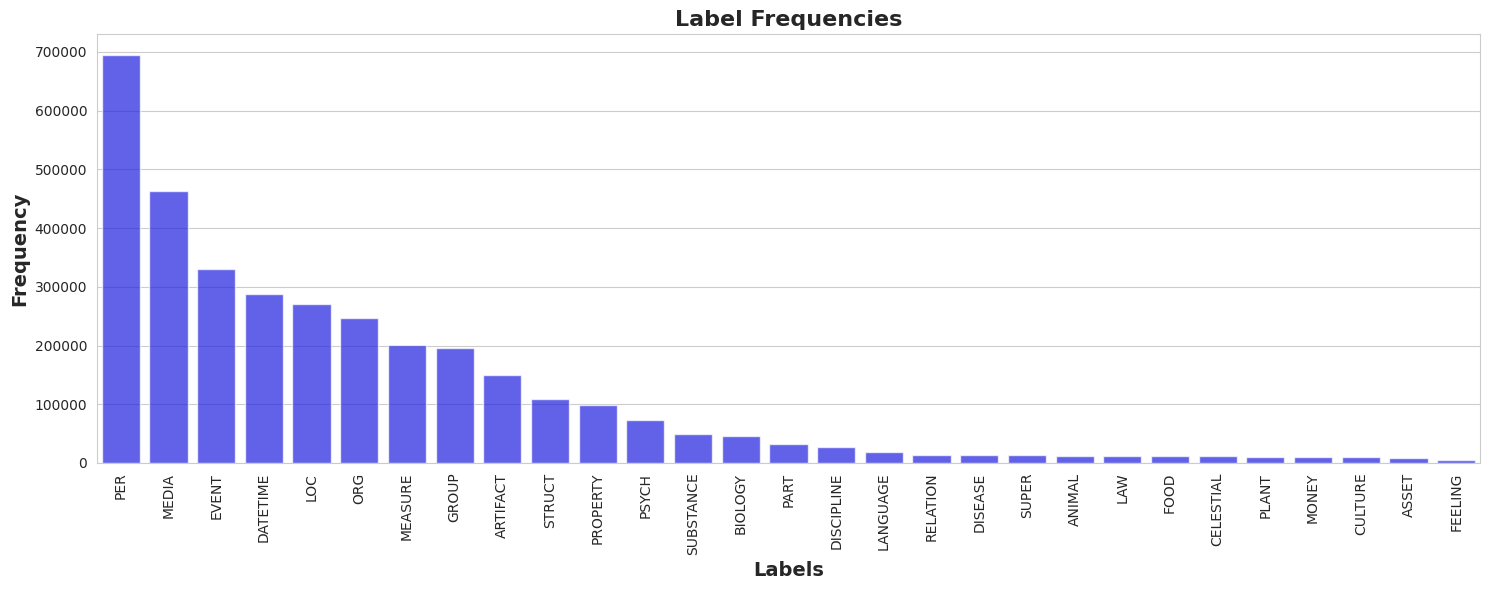

In [99]:
plot_freqs(joined_freqs, "Label Frequencies", rotation=90, xlabel="Labels", x_dict=None, remove_others=True)

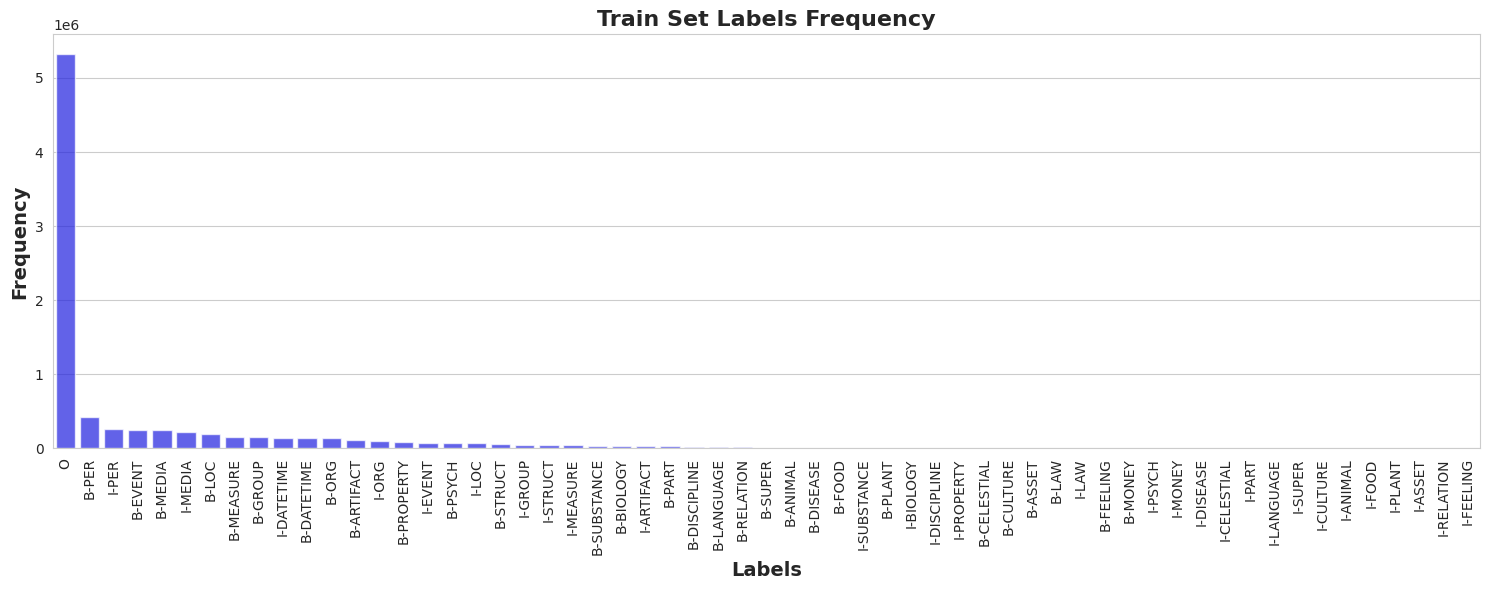

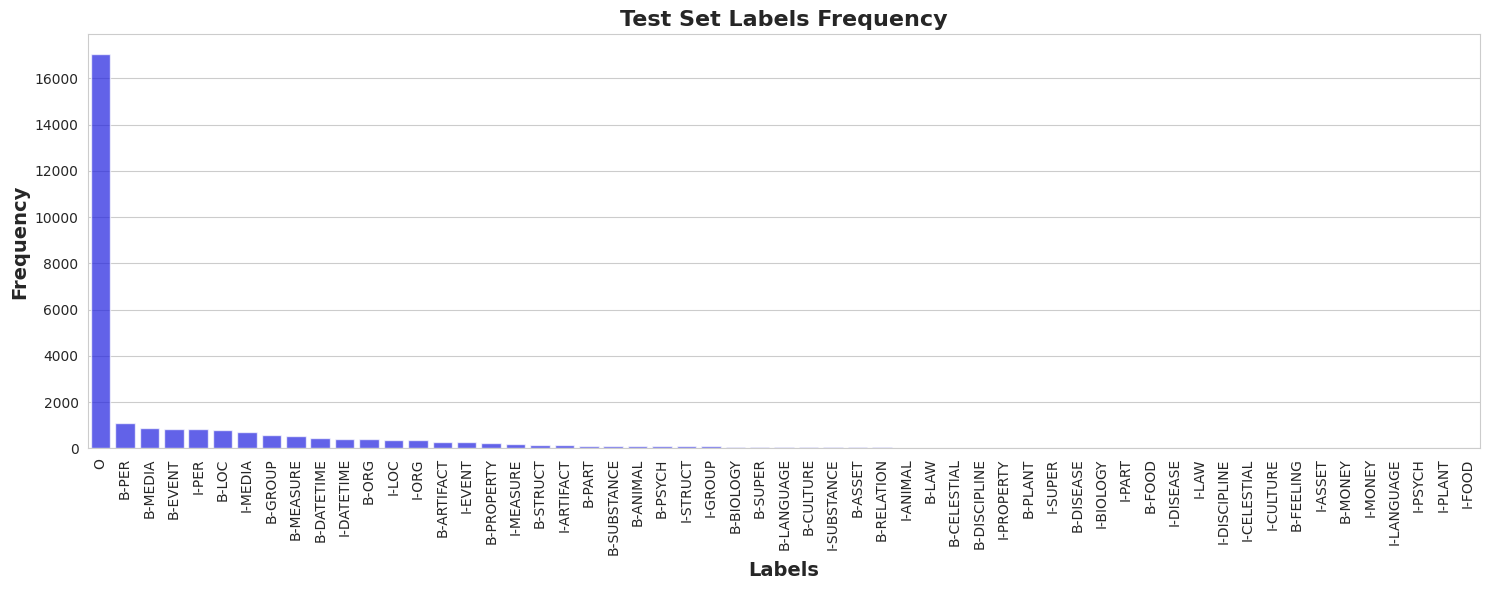

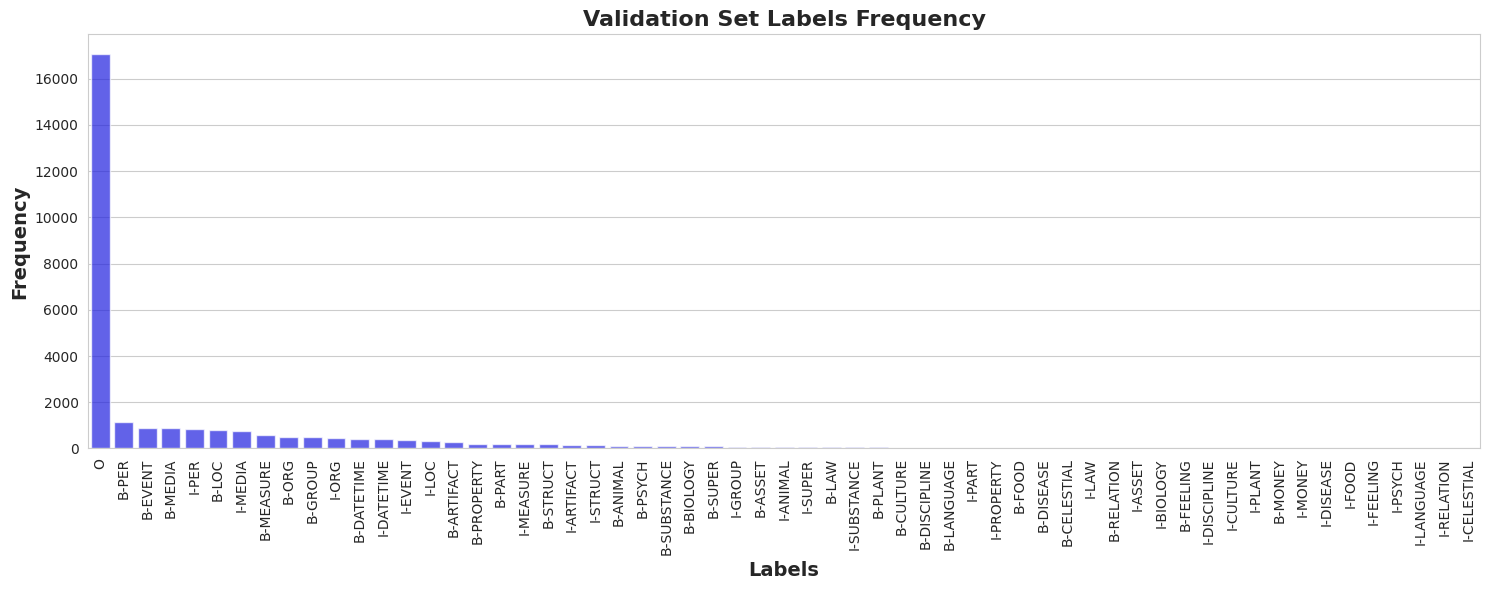

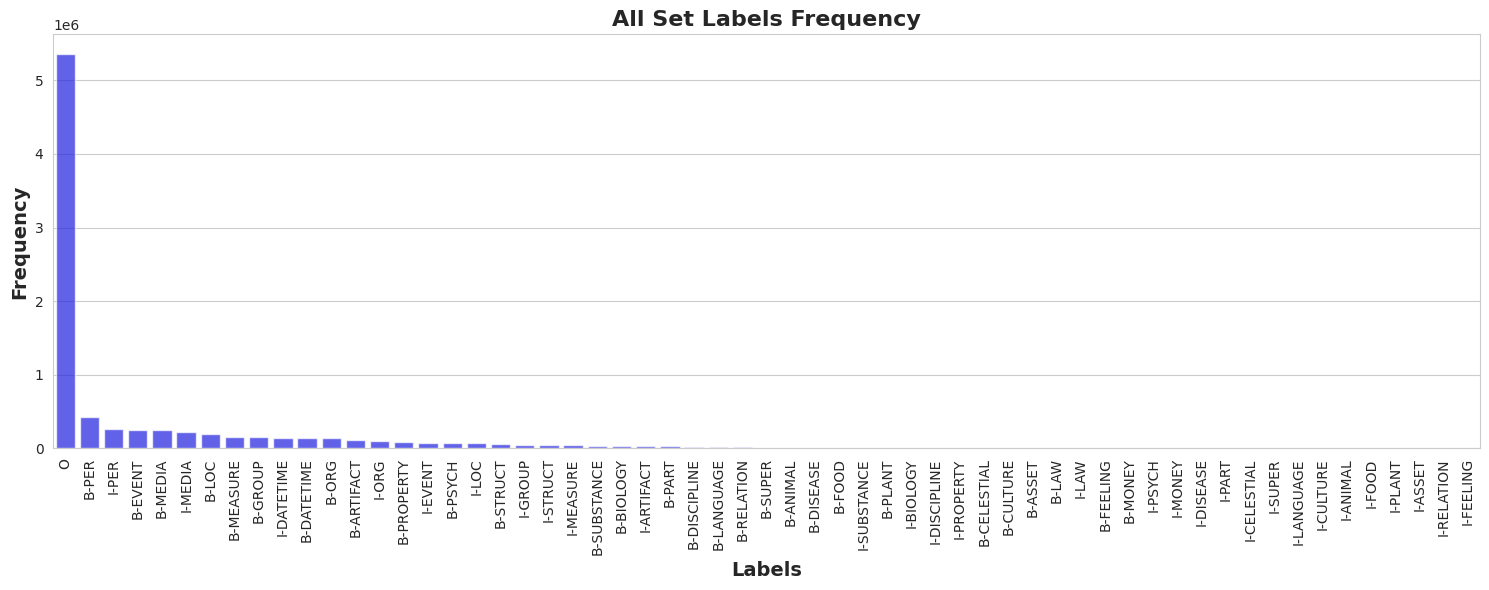

In [12]:
plot_freqs(label_freqs['train'], "Train Set Labels Frequency")
plot_freqs(label_freqs["test"], "Test Set Labels Frequency")
plot_freqs(label_freqs["valid"], "Validation Set Labels Frequency")
plot_freqs(sum(label_freqs.values(), Counter()), "All Set Labels Frequency")

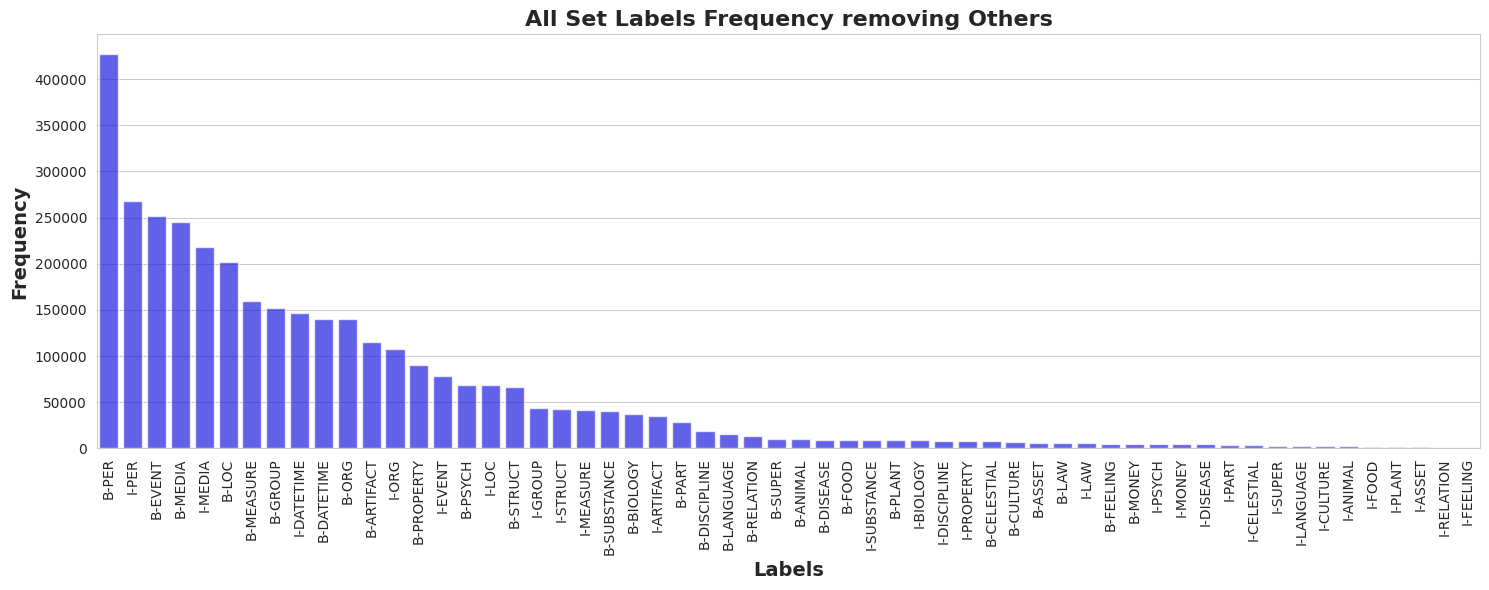

In [13]:
plot_freqs(sum(label_freqs.values(), Counter()), "All Set Labels Frequency removing Others", rotation=90, remove_others=True)

# Category frequency

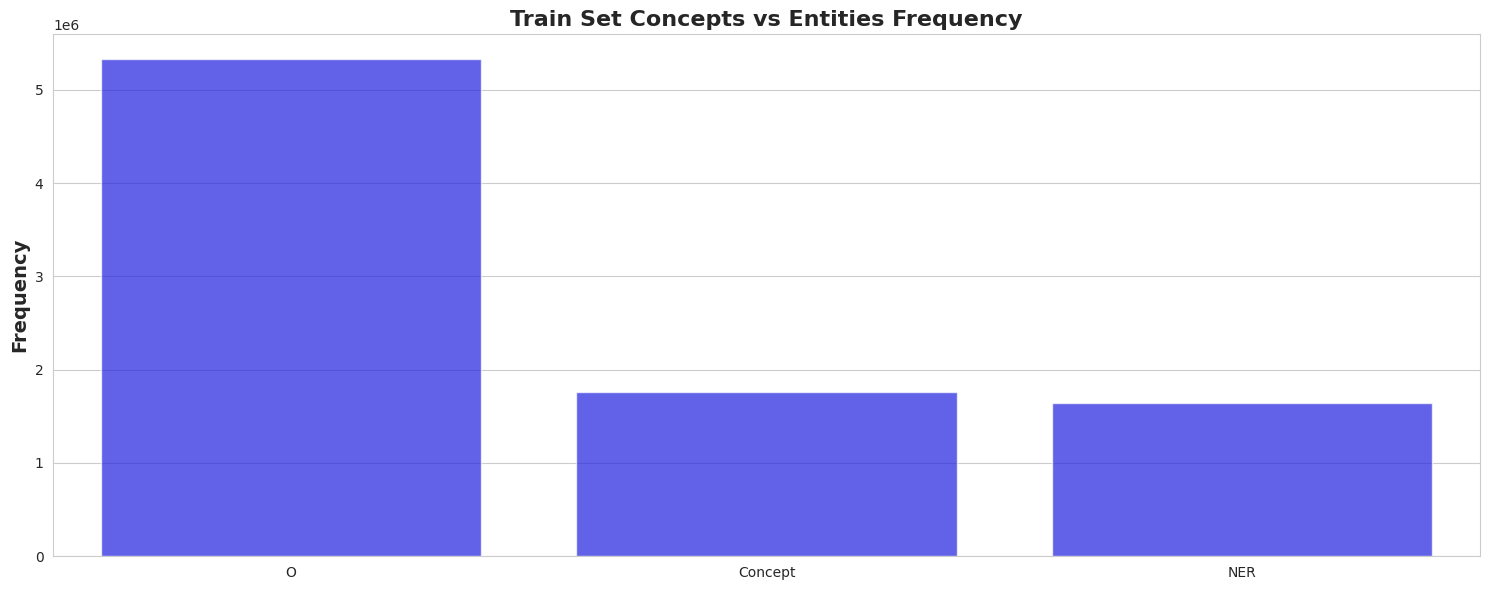

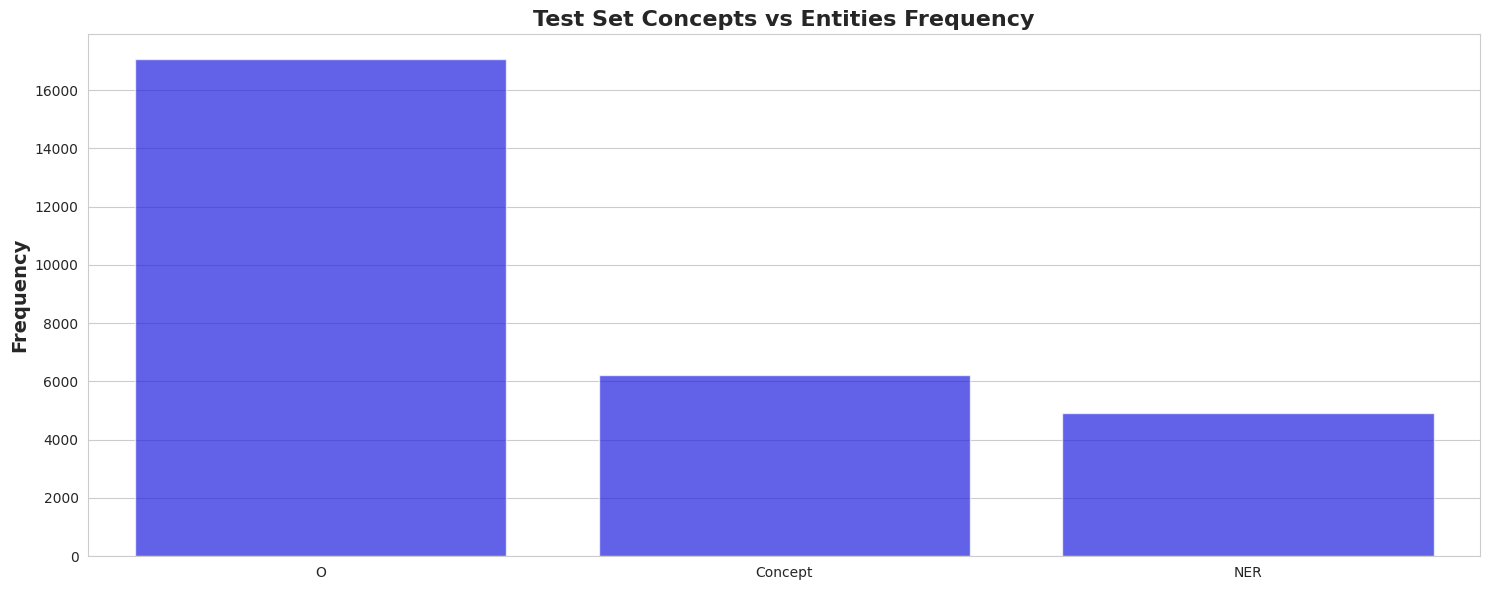

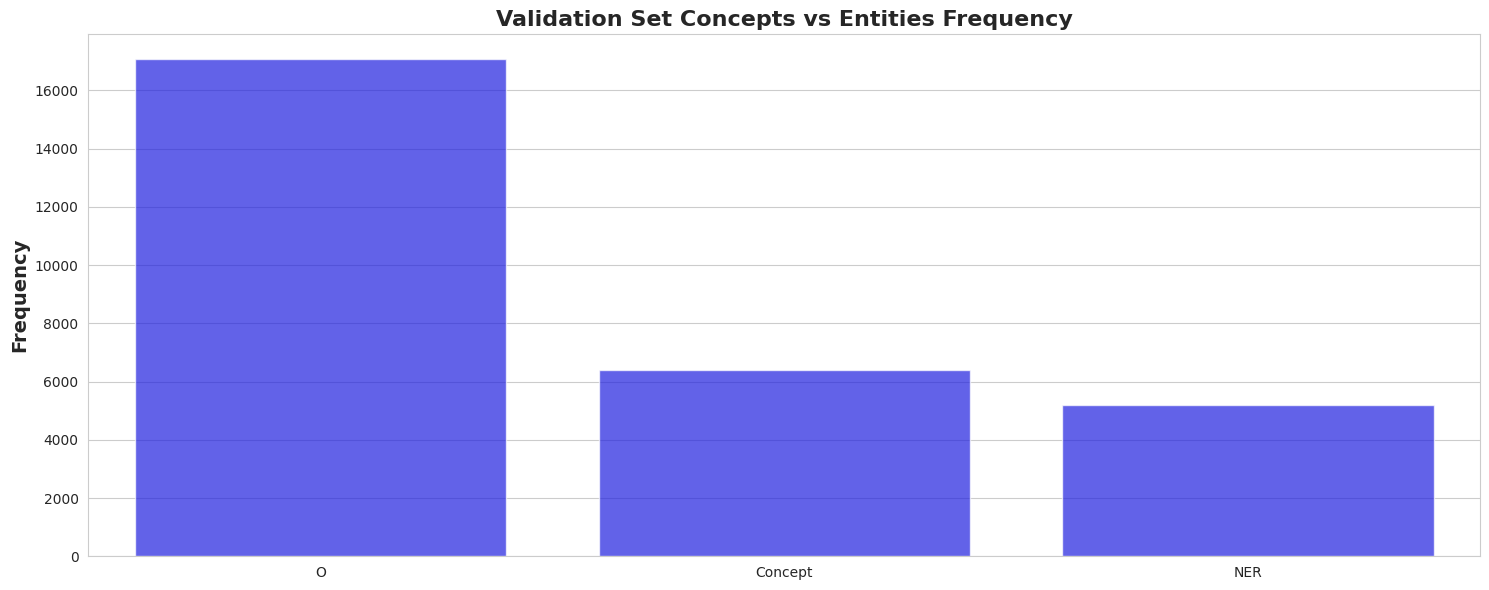

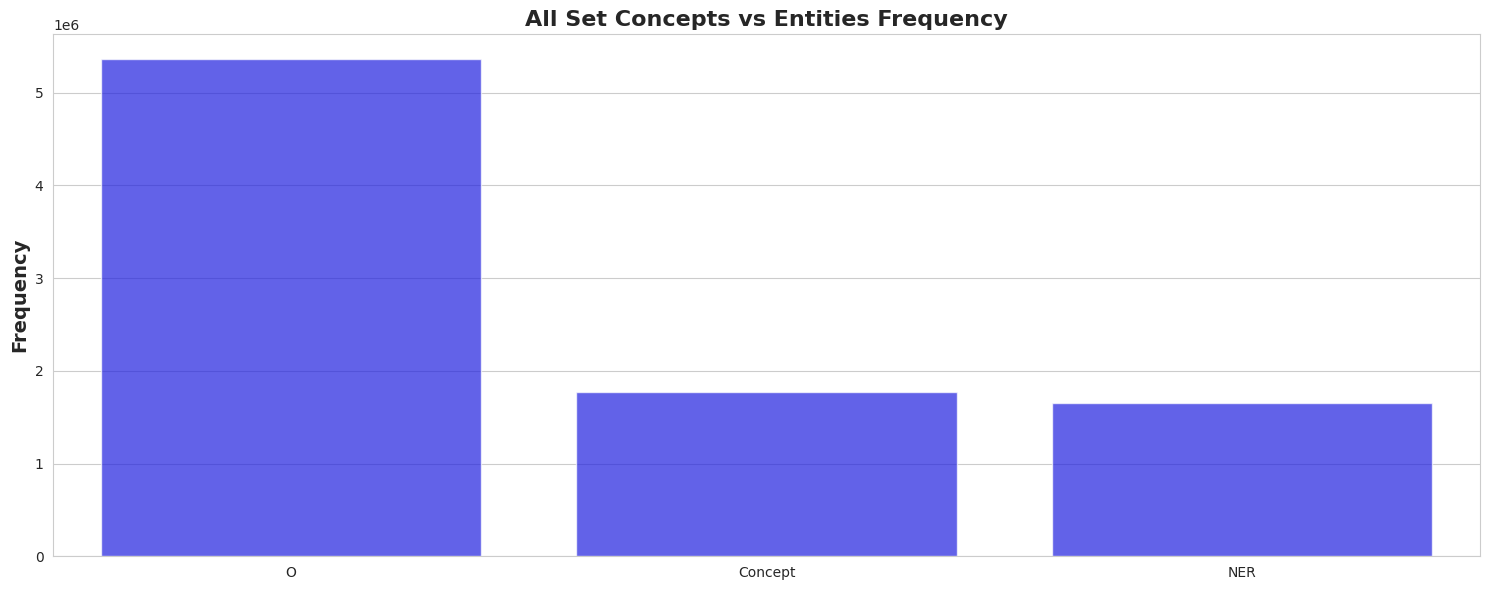

In [14]:
plot_freqs(entity_freqs["train"], "Train Set Concepts vs Entities Frequency", 0, "", {"O": "O", "C":"Concept", "NE":"NER"})
plot_freqs(entity_freqs["test"], "Test Set Concepts vs Entities Frequency", 0, "", {"O": "O", "C":"Concept", "NE":"NER"})
plot_freqs(entity_freqs["valid"], "Validation Set Concepts vs Entities Frequency", 0, "", {"O": "O", "C":"Concept", "NE":"NER"})
plot_freqs(sum(entity_freqs.values(), Counter()), "All Set Concepts vs Entities Frequency", 0, "", {"O": "O", "C":"Concept", "NE":"NER"})

In [82]:
entity_freqs_series = pd.Series(sum(entity_freqs.values(), Counter()))
entity_freqs_series = entity_freqs_series.rename(index={"O": "O", "C":"Concept", "NE":"NER"})
100 * entity_freqs_series / entity_freqs_series.sum()

NER        18.798630
O          61.044352
Concept    20.157018
dtype: float64

# Imbalance

In [31]:
joined_label_freqs = sum(label_freqs.values(), Counter())


In [50]:
counts = pd.Series(joined_label_freqs).sort_values(ascending=False) 

proportions = 100*counts / sum(joined_label_freqs.values())

In [51]:
proportions_without_others = 100*counts[counts.index != "O"] / sum(counts[counts.index != "O"].values)
proportions_without_others

B-PER           12.462080
I-PER            7.829386
B-EVENT          7.349941
B-MEDIA          7.169357
I-MEDIA          6.358044
B-LOC            5.885544
B-MEASURE        4.647957
B-GROUP          4.444348
I-DATETIME       4.287023
B-DATETIME       4.087354
B-ORG            4.076906
B-ARTIFACT       3.348648
I-ORG            3.136517
B-PROPERTY       2.647179
I-EVENT          2.301245
B-PSYCH          1.998794
I-LOC            1.996255
B-STRUCT         1.935759
I-GROUP          1.281508
I-STRUCT         1.240622
I-MEASURE        1.226790
B-SUBSTANCE      1.175370
B-BIOLOGY        1.076644
I-ARTIFACT       1.027150
B-PART           0.829552
B-DISCIPLINE     0.548171
B-LANGUAGE       0.443142
B-RELATION       0.392072
B-SUPER          0.313453
B-ANIMAL         0.288181
B-DISEASE        0.280447
B-FOOD           0.273414
I-SUBSTANCE      0.259261
B-PLANT          0.255496
I-BIOLOGY        0.252023
I-DISCIPLINE     0.251294
I-PROPERTY       0.245720
B-CELESTIAL      0.228794
B-CULTURE   

In [52]:
roots = set((tag.split('-')[-1] for tag in counts.index))
new_proportions = {}
for root in roots:
    new_proportions[root] = round(sum([proportions[tag] for tag in proportions.index if tag.endswith(root)]), 2)
new_proportions = dict(sorted(new_proportions.items(), key=lambda item: item[1], reverse=True))
pd.Series(new_proportions)

O             60.98
PER            8.07
MEDIA          5.28
EVENT          3.77
DATETIME       3.27
LOC            3.08
ORG            2.81
MEASURE        2.29
GROUP          2.23
ARTIFACT       1.71
STRUCT         1.24
PROPERTY       1.13
PSYCH          0.84
SUBSTANCE      0.56
BIOLOGY        0.52
PART           0.36
DISCIPLINE     0.31
LANGUAGE       0.20
DISEASE        0.16
RELATION       0.16
SUPER          0.15
LAW            0.14
ANIMAL         0.14
CELESTIAL      0.13
FOOD           0.13
PLANT          0.12
MONEY          0.11
CULTURE        0.11
ASSET          0.09
FEELING        0.06
dtype: float64

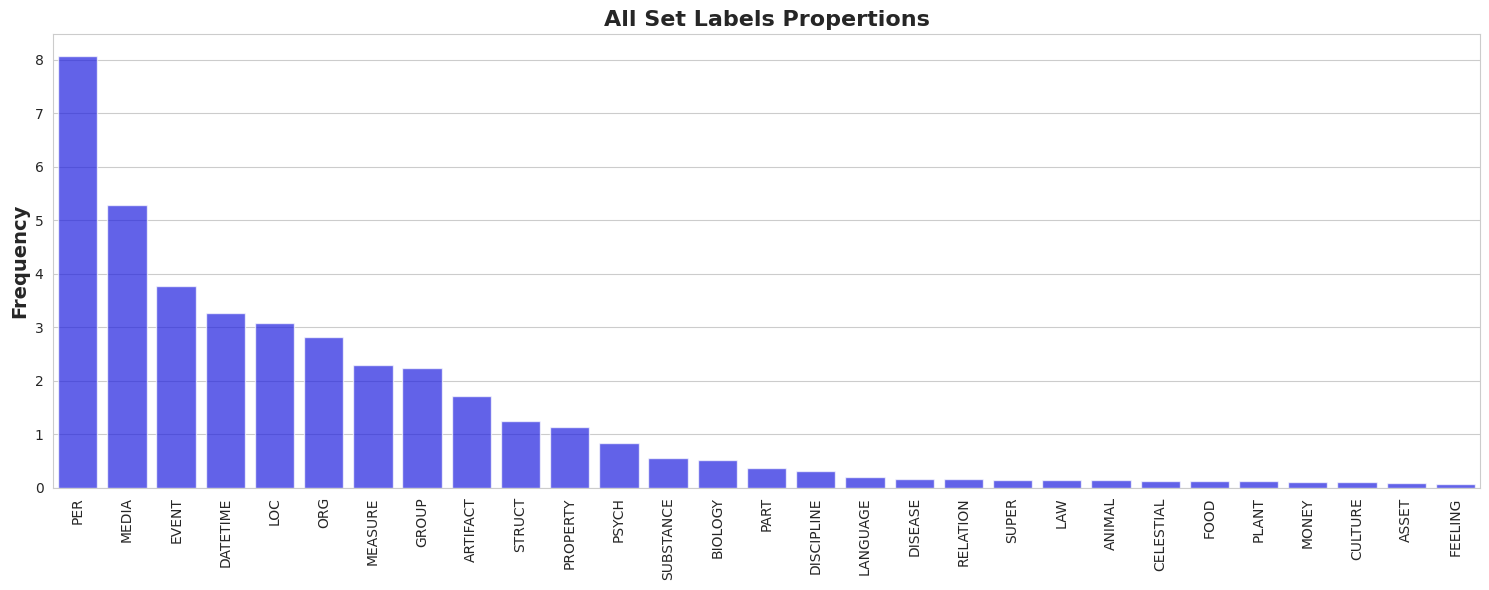

In [53]:
plot_freqs(new_proportions, "All Set Labels Propertions", 90, "", remove_others=True)

In [79]:
new_proportions_without_others = {}
for root in roots:
    if root == "O":
        continue
    new_proportions_without_others[root] = round(sum([proportions_without_others[tag] for tag in proportions_without_others.index if tag.endswith(root)]), 2)
new_proportions_without_others = dict(sorted(new_proportions_without_others.items(), key=lambda item: item[1], reverse=True))
pd.Series(new_proportions_without_others)

PER           41.78
MEDIA         27.06
EVENT         19.30
DATETIME      16.74
LOC           15.76
ORG           14.42
MEASURE       11.74
GROUP         11.46
ARTIFACT       8.76
STRUCT         6.36
PROPERTY       5.78
PSYCH          4.28
SUBSTANCE      2.86
BIOLOGY        2.66
PART           1.86
DISCIPLINE     1.60
LANGUAGE       1.06
RELATION       0.84
DISEASE        0.82
SUPER          0.80
LAW            0.70
ANIMAL         0.70
CELESTIAL      0.66
FOOD           0.66
PLANT          0.62
MONEY          0.58
CULTURE        0.58
ASSET          0.44
FEELING        0.32
dtype: float64

In [80]:
# pie chart
# plt.figure(figsize=(10, 10))
# plt.pie(new_proportions_without_others.values(), labels=new_proportions_without_others.keys(), autopct='%1.1f%%', startangle=140)
# plt.title("All Set Labels Proportions", fontsize=16, fontweight='bold')
# plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# plt.show()

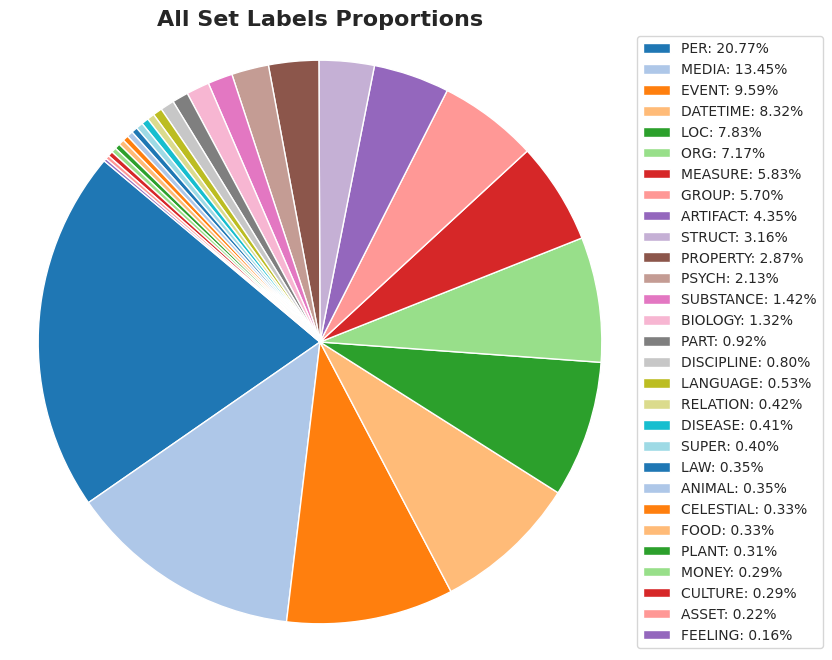

In [81]:
# Calculate percentages
total = sum(new_proportions_without_others.values())
percentages = {label: (value / total) * 100 for label, value in new_proportions_without_others.items()}

plt.figure(figsize=(8, 8))
wedges, texts = plt.pie(
    new_proportions_without_others.values(),
    startangle=140,
    colors=sns.color_palette("tab20", len(new_proportions_without_others))
)

# Create legend with percentages
legend_labels = [f"{label}: {percentages[label]:.2f}%" for label in new_proportions_without_others.keys()]
plt.legend(wedges, legend_labels, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title("All Set Labels Proportions", fontsize=16, fontweight='bold')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


# Example of annotated data

In [12]:
example = df_train.iloc[0][["tokens", "cner_tags", "c_vs_ne"]]
for token, tag, entity in zip(example["tokens"], example["cner_tags"], example["c_vs_ne"]):
    print(f"{token:<15}-> {tag:<15}-> {entity:<6}")

Erik           -> B-PER          -> NE    
Adolf          -> I-PER          -> NE    
von            -> I-PER          -> NE    
Willebrand     -> I-PER          -> NE    
(              -> O              -> O     
1              -> B-DATETIME     -> C     
February       -> I-DATETIME     -> C     
1870           -> I-DATETIME     -> C     
–              -> O              -> O     
12             -> B-DATETIME     -> C     
September      -> I-DATETIME     -> C     
1949           -> I-DATETIME     -> C     
)              -> O              -> O     
was            -> O              -> O     
a              -> O              -> O     
Finnish        -> B-GROUP        -> NE    
physician      -> B-PER          -> C     
who            -> O              -> O     
made           -> O              -> O     
major          -> O              -> O     
contributions  -> B-EVENT        -> C     
to             -> O              -> O     
hematology     -> B-DISCIPLINE   -> C     
.          

# Sentence length

In [15]:
df_train['sentence_length'] = df_train["tokens"].apply(len)

In [87]:
df_train['sentence_length'].sum() + df_valid['tokens'].map(len).sum() + df_test['tokens'].map(len).sum()

np.int64(8782688)

In [88]:
len(df_train), len(df_valid), len(df_test), len(df_train) + len(df_valid) + len(df_test)

(317590, 1000, 1000, 319590)

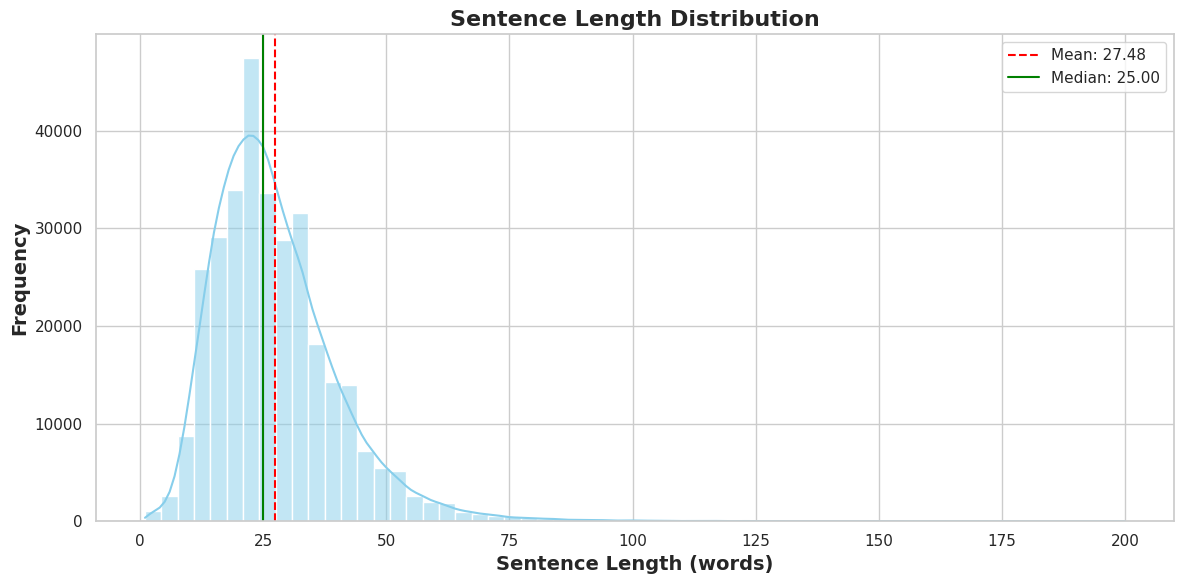

In [ ]:

def plot_sentence_length_distribution(sentence_lengths, title="Sentence Length Distribution"):
    plt.figure(figsize=(12, 6))
    sns.histplot(sentence_lengths, bins=60, kde=True, color='skyblue')
    mean_length = np.mean(sentence_lengths)
    median_length = np.median(sentence_lengths)
    plt.axvline(mean_length, color='red', linestyle='--', label=f'Mean: {mean_length:.2f}')
    plt.axvline(median_length, color='green', linestyle='-', label=f'Median: {median_length:.2f}')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel("Sentence Length (words)", fontsize=14, fontweight='bold')
    plt.ylabel("Frequency", fontsize=14, fontweight='bold')
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_sentence_length_distribution(df_train['sentence_length'].values)


$\rightarrow$ limit sentences to $75$

In [16]:
long_sentences = df_train[df_train['sentence_length'] > 100]

In [17]:
long_sentences

,sentence_id,tokens,pos,c_vs_ne,cner_tags,cner_tags_ids,sentence_length
2111,1684844.35,"[Many, other, parallels, and, inversions, abou...","[ADJ, ADJ, NOUN, CCONJ, NOUN, VERB, PUNCT, VER...","[O, O, C, O, C, O, O, O, O, O, C, C, C, O, O, ...","[O, O, B-PROPERTY, O, B-MEDIA, O, O, O, O, O, ...","[0, 0, 47, 0, 15, 0, 0, 0, 0, 0, 9, 10, 10, 0,...",115
2274,9570145.37,"[The, Story, of, Dida, Ibsen, (, 1918, ), Arou...","[DET, PROPN, ADP, PROPN, PROPN, PUNCT, NUM, PU...","[NE, NE, NE, NE, NE, O, C, O, NE, O, NE, NE, N...","[B-MEDIA, I-MEDIA, I-MEDIA, I-MEDIA, I-MEDIA, ...","[15, 16, 16, 16, 16, 0, 55, 0, 15, 0, 15, 16, ...",121
2797,2605773.33,"[Its, neighbouring, administrative, units, ,, ...","[PRON, VERB, ADJ, NOUN, PUNCT, ADV, ADP, DET, ...","[O, O, C, C, O, O, O, O, C, O, O, O, C, O, NE,...","[O, O, B-GROUP, I-GROUP, O, O, O, O, B-RELATIO...","[0, 0, 17, 18, 0, 0, 0, 0, 53, 0, 0, 0, 25, 0,...",119
9248,247205.38,"[Acanthophyllum, Achyronychia, –, onyxflower, ...","[PROPN, PROPN, PUNCT, X, PUNCT, NOUN, PUNCT, X...","[C, C, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[B-GROUP, I-GROUP, O, O, O, O, O, O, O, O, O, ...","[17, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",197
10401,891521.63,"[Due, to, similarly, severely, deformed, bones...","[ADP, ADP, ADV, ADV, VERB, NOUN, PUNCT, ADV, N...","[O, O, O, O, O, C, O, O, C, O, O, C, O, O, O, ...","[O, O, O, O, O, B-PART, O, O, B-PER, O, O, B-P...","[0, 0, 0, 0, 0, 43, 0, 0, 21, 0, 0, 51, 0, 0, ...",123
...,...,...,...,...,...,...,...
314004,39513921.40,"[Shailene, Woodley, as, Hazel, Grace, Lancaste...","[PROPN, PROPN, ADP, PROPN, PROPN, PROPN, PROPN...","[NE, NE, O, NE, NE, NE, NE, NE, O, O, NE, NE, ...","[B-PER, I-PER, O, B-PER, I-PER, I-PER, I-PER, ...","[21, 22, 0, 21, 22, 22, 22, 22, 0, 0, 21, 22, ...",153
314209,408264.88,"[Presidents, of, the, National, Committee, (, ...","[NOUN, ADP, DET, ADJ, PROPN, PUNCT, NUM, NUM, ...","[C, O, O, NE, NE, O, C, C, O, NE, NE, NE, O, C...","[B-PER, O, O, B-ORG, I-ORG, O, B-DATETIME, I-D...","[21, 0, 0, 19, 20, 0, 55, 56, 0, 21, 22, 22, 0...",188
314221,408264.105,"[Among, the, radical, leaders, at, this, time,...","[ADP, DET, ADJ, NOUN, ADP, DET, NOUN, AUX, PUN...","[O, O, O, C, O, O, C, O, O, NE, NE, NE, O, NE,...","[O, O, O, B-PER, O, O, B-MEASURE, O, O, B-PER,...","[0, 0, 0, 21, 0, 0, 33, 0, 0, 21, 22, 22, 0, 1...",111
315106,20031091.54,"[The, largest, of, these, killings, were, :, t...","[DET, ADJ, ADP, DET, NOUN, AUX, PUNCT, DET, PR...","[O, O, O, O, C, O, O, O, NE, NE, NE, C, O, O, ...","[O, O, O, O, B-EVENT, O, O, O, B-ORG, I-ORG, I...","[0, 0, 0, 0, 9, 0, 0, 0, 19, 20, 20, 9, 0, 0, ...",113


In [18]:
example = long_sentences.iloc[0][["tokens", "cner_tags", "c_vs_ne"]]
for token, tag, entity in zip(example["tokens"], example["cner_tags"], example["c_vs_ne"]):
    print(f"{token:<15}-> {tag:<15}-> {entity:<6}")

Many           -> O              -> O     
other          -> O              -> O     
parallels      -> B-PROPERTY     -> C     
and            -> O              -> O     
inversions     -> B-MEDIA        -> C     
abound         -> O              -> O     
,              -> O              -> O     
including      -> O              -> O     
:              -> O              -> O     
the            -> O              -> O     
difference     -> B-EVENT        -> C     
of             -> I-EVENT        -> C     
opinions       -> I-EVENT        -> C     
about          -> O              -> O     
the            -> O              -> O     
ease           -> B-PROPERTY     -> C     
of             -> O              -> O     
getting        -> O              -> O     
what           -> O              -> O     
is             -> O              -> O     
sought         -> O              -> O     
from           -> O              -> O     
the            -> O              -> O     
underworld 